# California Housing Prices: An In-Depth Analysis

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Load Dataset

In [107]:
#laod dataset
df_housing = pd.read_csv('housing.csv')

In [108]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Data Cleaning

#### Data Duplicate

In [109]:
#check total column duplicate
print('Total duplicate column is', df_housing.duplicated().sum(), 'column')

Total duplicate column is 0 column


#### Missing Value

In [110]:
#check missing value
def missing_value(x):
    if x.isna().sum().any():
        print('Have missing value')
    else:
        print('Dont have missing value')

In [111]:
#mising value of dataframe housing
missing_value(df_housing)

Have missing value


In [112]:
#check column that have missing value
df_housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [113]:
#check percentage of column that missing value
(df_housing.isna().sum()/len(df_housing))*100

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        1.002907
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64

In [114]:
#remove rows with missing values
housing_clean = df_housing.dropna()

In [115]:
#check column that have missing value
housing_clean.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

### Data Exploration

#### Data Visualization

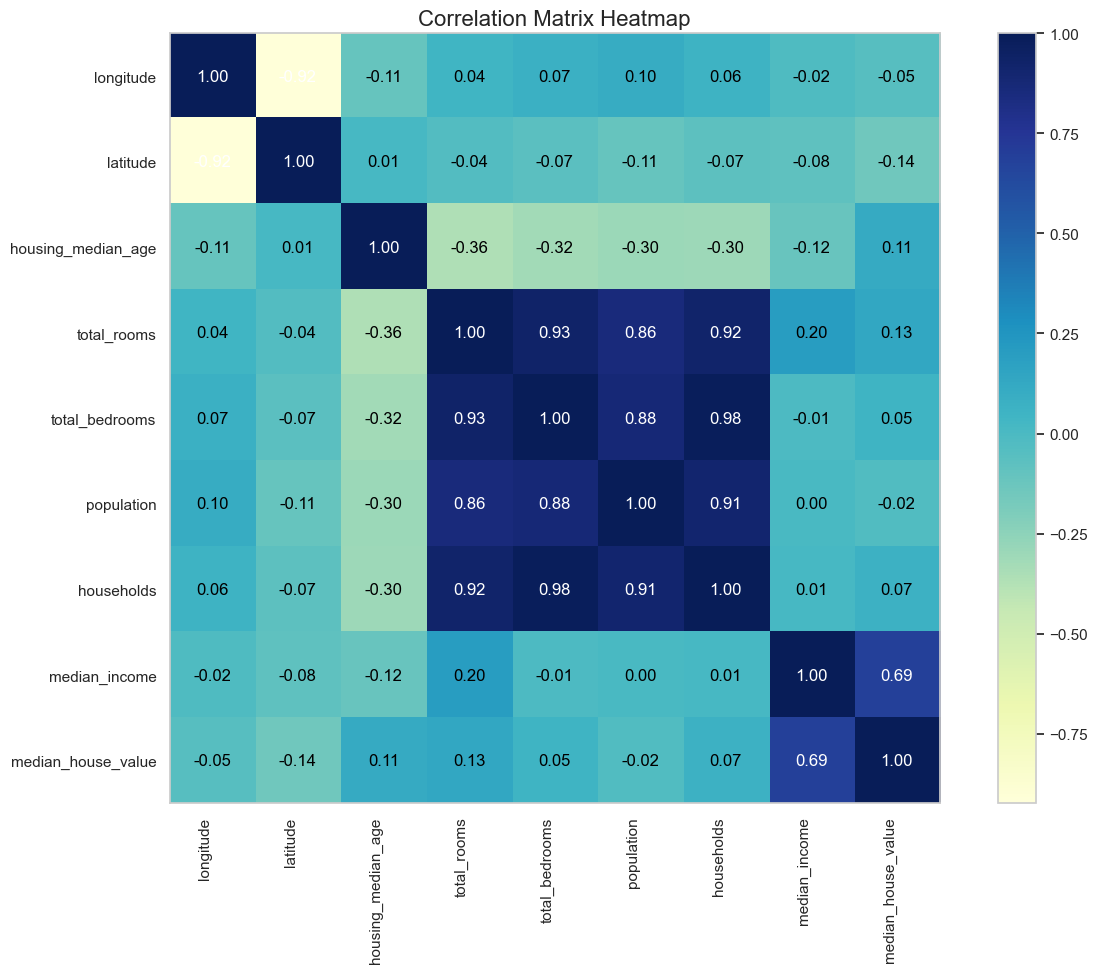

In [116]:
# Compute the correlation matrix
corr_matrix = df_housing.drop(['ocean_proximity'], axis=1).corr()

# Create the heatmap using Matplotlib
plt.figure(figsize=(15, 10))
heatmap = plt.imshow(corr_matrix, cmap='YlGnBu')
plt.colorbar(heatmap)

# Add annotations
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        value = corr_matrix.iloc[i, j]
        color = 'white' if abs(value) > 0.5 else 'black'
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha='center', va='center', color=color)

# Add labels
plt.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns, rotation=90, ha='right')
plt.yticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns)

plt.gca().grid(False)

# Add title
plt.title('Correlation Matrix Heatmap', fontsize=16)

# Show the plot
plt.show()

<Axes: xlabel='latitude', ylabel='longitude'>

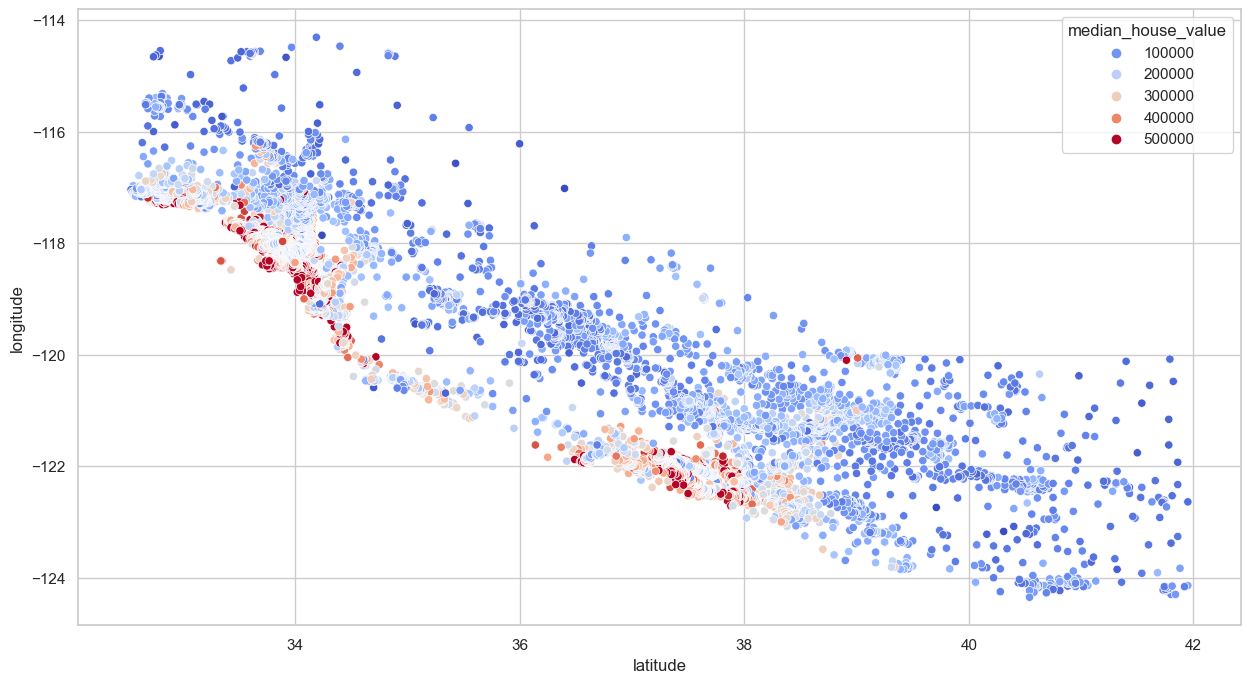

In [117]:
plt.figure(figsize = (15,8))
sns.scatterplot(x='latitude', y='longitude', data=df_housing, hue='median_house_value', palette='coolwarm')

c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


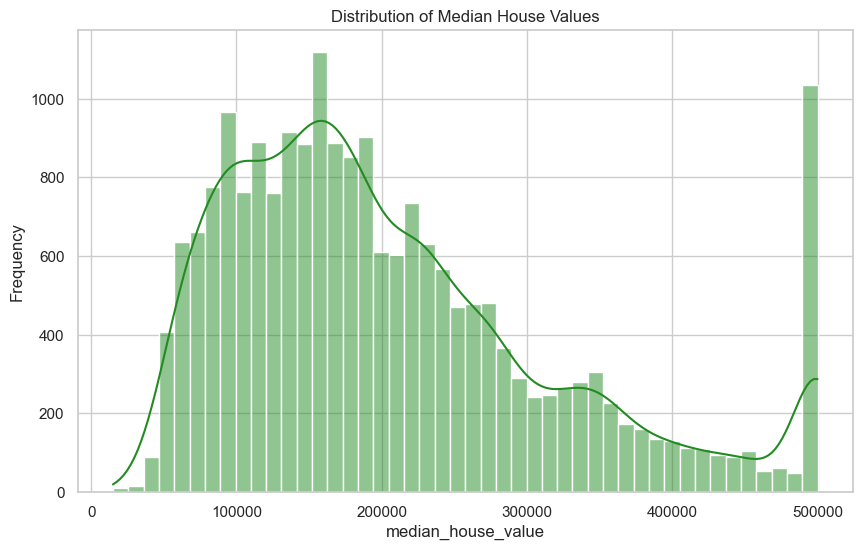

In [118]:
sns.set(style='whitegrid')
plt.figure(figsize=(10,6))
sns.histplot(df_housing['median_house_value'], color='forestgreen', kde=True)
plt.title('Distribution of Median House Values')
plt.ylabel('Frequency')
plt.show()

#### Data Outliers

In [119]:
#function for check outliear
def check_outliers(x):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print('Lower bound', lower_bound)
    print('Upper Bound', upper_bound)

    return lower_bound, upper_bound, Q1, Q3, IQR

In [120]:
#check outliears for house value
lower_bound, upper_bound, Q1, Q3, IQR = check_outliers(housing_clean['median_house_value'])

Lower bound -98300.0
Upper Bound 482500.0


In [121]:
#cleaning data from outliers
housing_nooutliers = housing_clean[
    (housing_clean['median_house_value']>=lower_bound) & (housing_clean['median_house_value']<=upper_bound) 
]

c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


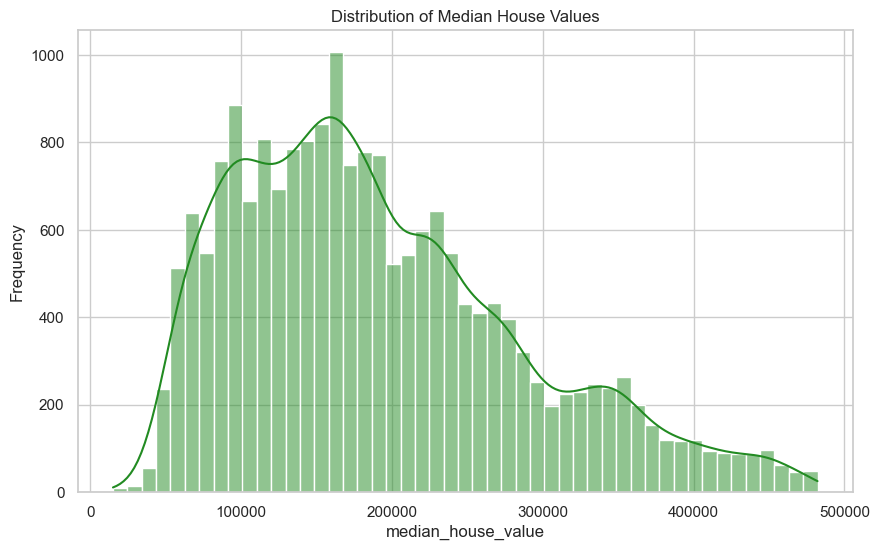

In [122]:
sns.set(style='whitegrid')
plt.figure(figsize=(10,6))
sns.histplot(housing_nooutliers['median_house_value'], color='forestgreen', kde=True)
plt.title('Distribution of Median House Values')
plt.ylabel('Frequency')
plt.show()

### Data Train/Test

#### Linear Regression

In [158]:
housing_nooutliers.drop(['ocean_proximity'], axis=1).describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,19369.000000,19369.000000,19369.000000,19369.000000,19369.000000,19369.000000,19369.000000,19369.000000,19369.000000
mean,-119.563902,35.655784,28.344158,2620.710930,539.893335,1442.285043,501.303991,3.665475,190802.064949
std,2.005895,2.151468,12.503931,2187.046669,422.650225,1145.780125,383.339200,1.556776,95404.934086
min,-124.350000,32.540000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.760000,33.930000,18.000000,1440.000000,297.000000,798.000000,282.000000,2.522300,116100.000000
50%,-118.510000,34.270000,28.000000,2110.000000,437.000000,1181.000000,411.000000,3.442700,173200.000000
75%,-117.990000,37.730000,37.000000,3119.000000,648.000000,1746.000000,606.000000,4.572400,246400.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,482200.000000


In [160]:
housing_feature = housing_nooutliers[[
    'households',
    'housing_median_age',
    # 'latitude',
    # 'longitude',
    'median_income',
    'ocean_proximity',
    'population',
    'total_bedrooms',
    'total_rooms'
]]

housing_target = housing_nooutliers[
    'median_house_value'
]

housing_feature = pd.get_dummies(
    housing_feature, columns=[
        'ocean_proximity'
    ], prefix='ocean'
)
housing_feature = housing_feature.drop(['ocean_<1H OCEAN'], axis=1)

In [161]:
X_train, X_test, y_train, y_test = train_test_split(housing_feature, housing_target, test_size=0.2, random_state=42)

In [162]:
housing_model = LinearRegression()

In [163]:
housing_model.fit(X_train, y_train)
y_pred = housing_model.predict(X_test)

In [164]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

In [165]:
set(housing_feature)

{'households',
 'housing_median_age',
 'median_income',
 'ocean_INLAND',
 'ocean_ISLAND',
 'ocean_NEAR BAY',
 'ocean_NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms'}

### Prediction 

In [191]:
def predicting_house(
    households,
    housing_median_age,
    # latitude,
    # longitude,
    median_income,
    population,
    total_bedrooms,
    total_rooms 
):
    new_data = pd.DataFrame({
        'households':[households],
        'housing_median_age':[housing_median_age],
        # 'latitude':[latitude],
        # 'longitude':[longitude],
        'median_income':[median_income],
        'population':[population],
        'total_bedrooms':[total_bedrooms],
        'total_rooms':[total_rooms],
        'ocean_INLAND':[0],
        'ocean_ISLAND':[0],
        'ocean_NEAR BAY':[0],
        'ocean_NEAR OCEAN':[0]
    })

    price_1H_ocean = housing_model.predict(new_data)[0]

    new_data['ocean_INLAND'] = 1
    price_ocena_inland = housing_model.predict(new_data)[0]

    new_data['ocean_INLAND'] = 0
    new_data['ocean_ISLAND'] = 1
    price_ocean_island = housing_model.predict(new_data)[0]

    new_data['ocean_INLAND'] = 0
    new_data['ocean_ISLAND'] = 0
    new_data['ocean_NEAR BAY'] = 1
    price_ocean_nearbay = housing_model.predict(new_data)[0]

    new_data['ocean_INLAND'] = 0
    new_data['ocean_ISLAND'] = 0
    new_data['ocean_NEAR BAY'] = 0
    new_data['ocean_NEAR OCEAN'] = 1
    price_ocean_nearocean = housing_model.predict(new_data)[0]

    prices = {
        'ocean_1h':price_1H_ocean,
        'ocean_inland':price_ocena_inland,
        'ocean_island':price_ocean_island,
        'ocean_nearbay':price_ocean_nearbay,
        'ocean_nearocean':price_ocean_nearocean
    }
    prices = {
        k:'{:,.0f}'.format(v) for k, v in prices.items()
    }
    best_price_loc = max(prices, key=prices.get)
    return best_price_loc, prices

households_input=306
housing_median_age_input=52
# latitude_input=-118.3
# longitude_input=34.08
median_income_input=3.125
population_input=891.0
total_bedrooms_input=280.0
total_rooms_input=1527.0

best_location, predictions = predicting_house(
    households_input,
    housing_median_age_input,
    # latitude_input,
    # longitude_input,
    median_income_input,
    population_input,
    total_bedrooms_input,
    total_rooms_input
)

In [192]:
predictions

{'ocean_1h': '204,478',
 'ocean_inland': '142,508',
 'ocean_island': '424,105',
 'ocean_nearbay': '206,877',
 'ocean_nearocean': '217,839'}